# 1. Creating necessary directories

In [ ]:
import os
import shutil
import glob
import random


# Define folder paths
folder_path = "/kaggle/input/stanford-dogs-dataset/images/Images/*"
op_path_similar = "/kaggle/working/similar_all_images"
tmp = "/kaggle/working/tmp"
op_path_dissimilar = "/kaggle/working/dissimilar_all_images"
dataset_folder= "/kaggle/working/image_similarity"

# Function to create folder if it doesn't exist
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")

# Create folders if they don't exist
create_folder_if_not_exists(op_path_similar)
create_folder_if_not_exists(tmp)
create_folder_if_not_exists(op_path_dissimilar)
create_folder_if_not_exists(dataset_folder)


print("Folders created successfully!")


# 2. Copying, Moving, and Renaming file for dataset creation

In [19]:

# Function to copy files
def copy_files(source_folder, files_list, des):
    for file in files_list:
        source_file = os.path.join(source_folder, file)
        des_file = os.path.join(des, file)
        shutil.copy2(source_file, des_file)
        print(f"Copied {file} to {des}")
    return
    
# Function to move files
def move_files(source_folder, des):
    files_list = os.listdir(source_folder)
    for file in files_list:
        source_file = os.path.join(source_folder, file)
        des_file = os.path.join(des, file)
        shutil.move(source_file, des_file)
        print(f"Moved {file} to {des}")
    return

# Function to rename files
def rename_file(file_path, new_name):
    directory = os.path.dirname(file_path)
    new_file_path = os.path.join(directory, new_name)
    os.rename(file_path, new_file_path)
    print(f"File renamed to {new_file_path}")
    return

# Adjust your folder paths here
folder_path = "/kaggle/input/stanford-dogs-dataset/images/Images/*"
op_path_similar = "/kaggle/working/similar_all_images"
tmp = "/kaggle/working/tmp"
op_path_dissimilar = "/kaggle/working/dissimilar_all_images"

folders_list = glob.glob(folder_path)
folders_list = list(set(folders_list).difference(set([op_path_similar, tmp, op_path_dissimilar])))

l, g = 0, 0

random.shuffle(folders_list)
for i in glob.glob(folder_path):
    if i in [op_path_similar, tmp, op_path_dissimilar]:
        continue
    
    # Extract breed name from folder path
    breed_name = i.split('/')[-1].split("-")[1]
    picked_files = random.sample(os.listdir(i), 6)  # Randomly pick 6 files
    
    copy_files(i, picked_files, tmp)
    
    for m in range(3):
        rename_file(os.path.join(tmp, picked_files[m*2]), f"similar_{g}_first.jpg")
        rename_file(os.path.join(tmp, picked_files[m*2+1]), f"similar_{g}_second.jpg")
        g += 1
    
    move_files(tmp, op_path_similar)
    
    choice_one, choice_two = random.choice(range(len(folders_list))), random.choice(range(len(folders_list)))
    picked_dissimilar_one = random.sample(os.listdir(folders_list[choice_one]), 3)
    picked_dissimilar_two = random.sample(os.listdir(folders_list[choice_two]), 3)
    
    copy_files(folders_list[choice_one], picked_dissimilar_one, tmp)
    copy_files(folders_list[choice_two], picked_dissimilar_two, tmp)
    
    picked_files_dissimilar = picked_dissimilar_one + picked_dissimilar_two
    
    for m in range(3):
        rename_file(os.path.join(tmp, picked_files_dissimilar[m]), f"dissimilar_{l}_first.jpg")
        rename_file(os.path.join(tmp, picked_files_dissimilar[m+3]), f"dissimilar_{l}_second.jpg")
        l += 1
    
    move_files(tmp, op_path_dissimilar)


Copied n02091635_1568.jpg to /kaggle/working/tmp
Copied n02091635_4377.jpg to /kaggle/working/tmp
Copied n02091635_2084.jpg to /kaggle/working/tmp
Copied n02091635_2183.jpg to /kaggle/working/tmp
Copied n02091635_335.jpg to /kaggle/working/tmp
Copied n02091635_2482.jpg to /kaggle/working/tmp
File renamed to /kaggle/working/tmp/similar_0_first.jpg
File renamed to /kaggle/working/tmp/similar_0_second.jpg
File renamed to /kaggle/working/tmp/similar_1_first.jpg
File renamed to /kaggle/working/tmp/similar_1_second.jpg
File renamed to /kaggle/working/tmp/similar_2_first.jpg
File renamed to /kaggle/working/tmp/similar_2_second.jpg
Moved similar_1_second.jpg to /kaggle/working/similar_all_images
Moved similar_0_second.jpg to /kaggle/working/similar_all_images
Moved similar_0_first.jpg to /kaggle/working/similar_all_images
Moved similar_1_first.jpg to /kaggle/working/similar_all_images
Moved similar_2_second.jpg to /kaggle/working/similar_all_images
Moved similar_2_first.jpg to /kaggle/working/

# 3. Create the Dataset

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import random


from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        self.transform = transforms.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        
        transforms.Resize((256,256)),
         transforms.ToTensor()
                                    
    ]
)
        self.image_pairs = self.load_image_pairs()

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        image1_path, image2_path, label = self.image_pairs[idx]
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        
    
        # Convert the tensor to a PIL image
        # image1 = functional.to_pil_image(image1)
        # image2 = functional.to_pil_image(image2)
        
        image1 = self.transform(image1)
        image2 = self.transform(image2)
        # image1 = torch.clamp(image1, 0, 1)
        # image2 = torch.clamp(image2, 0, 1)
        return image1, image2, label

    def load_image_pairs(self):
        image_pairs = []
        # Assume the directory structure is as follows:
        # root_dir
        # ├── similar
        # │   ├── similar_image1.jpg
        # │   ├── similar_image2.jpg
        # │   └── ...
        # └── dissimilar
        #     ├── dissimilar_image1.jpg
        #     ├── dissimilar_image2.jpg
        #     └── ...
        similar_dir = os.path.join(self.root_dir, "similar_all_images")
        dissimilar_dir = os.path.join(self.root_dir, "dissimilar_all_images")

        # Load similar image pairs with label 1
        similar_images = os.listdir(similar_dir)
        for i in range(len(similar_images) // 2):
            image1_path = os.path.join(similar_dir, f"similar_{i}_first.jpg")
            image2_path = os.path.join(similar_dir, f"similar_{i}_second.jpg")
            image_pairs.append((image1_path, image2_path, 0))

        # Load dissimilar image pairs with label 0
        dissimilar_images = os.listdir(dissimilar_dir)
        for i in range(len(dissimilar_images) // 2):
            image1_path = os.path.join(dissimilar_dir, f"dissimilar_{i}_first.jpg")
            image2_path = os.path.join(dissimilar_dir, f"dissimilar_{i}_second.jpg")
            image_pairs.append((image1_path, image2_path, 1))

        return image_pairs
      
dataset = ImagePairDataset(r"/kaggle/working")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. create the Siamese Neural Network

In [21]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        # self.cnn1 = nn.Sequential(
        #     nn.Conv2d(3, 256, kernel_size=11,stride=4),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(3, stride=2),
            
        #     nn.Conv2d(256, 256, kernel_size=5, stride=1),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2, stride=2),

        #     nn.Conv2d(256, 384, kernel_size=3,stride=1),
        #     nn.ReLU(inplace=True)
        # )
        
        self.cnn1=nn.Conv2d(3, 256, kernel_size=11,stride=4)
        self.relu = nn.ReLU()
        self.maxpool1=nn.MaxPool2d(3, stride=2)
        self.cnn2=nn.Conv2d(256, 256, kernel_size=5,stride=1)
        self.maxpool2=nn.MaxPool2d(2, stride=2)
        self.cnn3=nn.Conv2d(256, 384, kernel_size=3,stride=1)
        self.fc1 =nn.Linear(46464, 1024)
        self.fc2=nn.Linear(1024, 256)
        self.fc3=nn.Linear(256, 1)
        # Setting up the Fully Connected Layers
        # self.fc1 = nn.Sequential(
        #     nn.Linear(384, 1024),
        #     nn.ReLU(inplace=True),
            
        #     nn.Linear(1024, 32*46464),
        #     nn.ReLU(inplace=True),
            
        #     nn.Linear(32*46464,1)
        # )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        # output = self.cnn1(x)
        # print(output.view(output.size()[0], -1).shape)
        # output = output.view(output.size()[0], -1)
        # output = self.fc1(output)
        # print(x.shape)
        output= self.cnn1(x)
        # print(output.shape)
        output=self.relu(output)
        # print(output.shape)
        output=self.maxpool1(output)
        # print(output.shape)
        output= self.cnn2(output)
        # print(output.shape)
        output=self.relu(output)
        # print(output.shape)
        output=self.maxpool2(output)
        # print(output.shape)
        output= self.cnn3(output)
        output=self.relu(output)
        # print(output.shape)
        output=output.view(output.size()[0], -1)
        # print(output.shape)
        output=self.fc1(output)
        # print(output.shape)
        output=self.fc2(output)
        # print(output.shape)
        output=self.fc3(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

# 5. Define the ContrastiveLoss

In [22]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive
      
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

# 6. Train the model

In [23]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_loader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())



Epoch number 0
 Current loss 2.487339973449707

Epoch number 0
 Current loss 1.4790761470794678

Epoch number 1
 Current loss 1.300722360610962

Epoch number 1
 Current loss 1.4414929151535034

Epoch number 2
 Current loss 1.4438023567199707

Epoch number 2
 Current loss 1.4878264665603638

Epoch number 3
 Current loss 0.9614662528038025

Epoch number 3
 Current loss 1.3250691890716553

Epoch number 4
 Current loss 1.3105665445327759

Epoch number 4
 Current loss 1.4298204183578491

Epoch number 5
 Current loss 1.5935801267623901

Epoch number 5
 Current loss 1.4964933395385742

Epoch number 6
 Current loss 1.7985024452209473

Epoch number 6
 Current loss 1.342866063117981

Epoch number 7
 Current loss 1.3932290077209473

Epoch number 7
 Current loss 1.480538010597229

Epoch number 8
 Current loss 1.1539044380187988

Epoch number 8
 Current loss 1.2566423416137695

Epoch number 9
 Current loss 1.3189250230789185

Epoch number 9
 Current loss 1.298484444618225

Epoch number 10
 Current 

NameError: name 'show_plot' is not defined

# 7. Plot the result

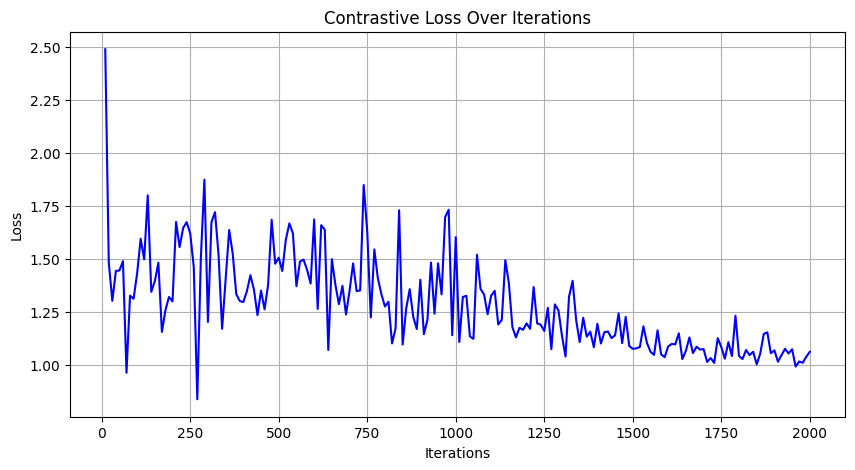

In [24]:
import matplotlib.pyplot as plt

def show_plot(counter, loss_history):
    plt.figure(figsize=(10,5))
    plt.plot(counter, loss_history, color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Contrastive Loss Over Iterations')
    plt.grid(True)
    plt.show()

show_plot(counter, loss_history)

# 8. Test the model on evaluation metrics

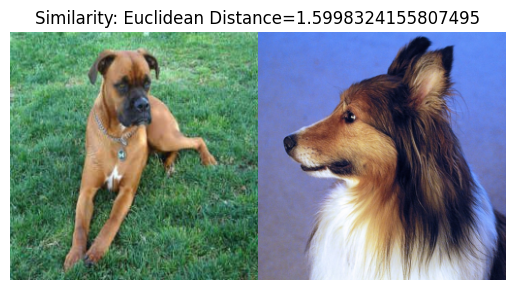

Cosine Similarity: 0.8279
Pearson Correlation: 0.0088
SSIM: 0.9896145178833929


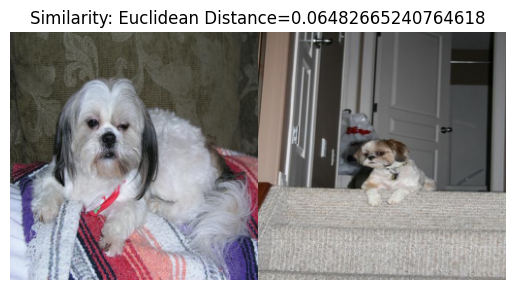

Cosine Similarity: 0.8938
Pearson Correlation: 0.4046
SSIM: 0.9925395455235653


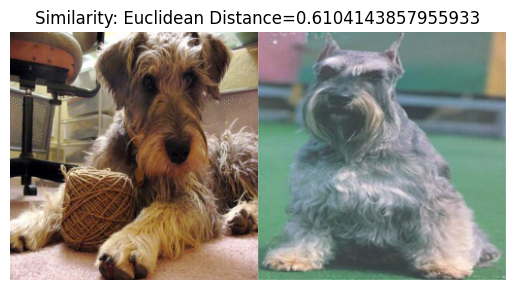

Cosine Similarity: 0.8226
Pearson Correlation: -0.0467
SSIM: 0.988550934841491


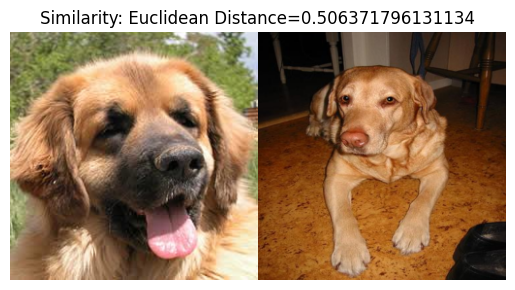

Cosine Similarity: 0.6886
Pearson Correlation: -0.0027
SSIM: 0.9793309515949679


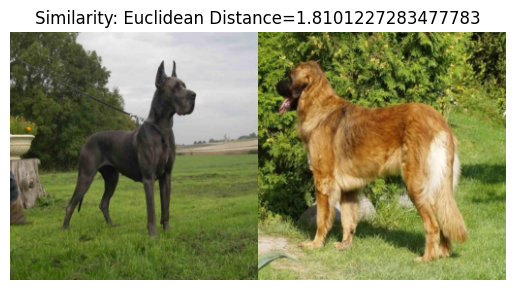

Cosine Similarity: 0.7467
Pearson Correlation: -0.0116
SSIM: 0.9854479187667478


In [51]:
from skimage.metrics import structural_similarity as compare_ssim
from scipy.stats import pearsonr

# Set the Siamese network to evaluation mode
net.eval()

# Create a DataLoader for the test dataset with batch size 1
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataiter = iter(test_loader_one)

# Iterate over pairs of images from the test dataset
for i in range(5):
    # Extract a pair of images from the test dataset
    img0, img1, label = next(dataiter)

    # Pass the pair of images through the Siamese network
    output1, output2 = net(img0.cuda(), img1.cuda())

    # Calculate the euclidean distance between the output vectors
    euclidean_distance = F.pairwise_distance(output1, output2)

    # Concatenate the pair of images for visualization
    concatenated = torch.cat((img0, img1), 3)

    # Display the concatenated images using imshow function
    imshow(torchvision.utils.make_grid(concatenated), f'Similarity: Euclidean Distance={euclidean_distance.item()}')

    # Convert tensors to NumPy arrays for cosine similarity and pearson correlation
    image1_np = img0.squeeze().cpu().numpy()
    image2_np = img1.squeeze().cpu().numpy()

    # Flatten the arrays for cosine similarity
    image1_flat = image1_np.flatten()
    image2_flat = image2_np.flatten()

    # Calculate cosine similarity
    cosine_similarity = np.dot(image1_flat, image2_flat) / (np.linalg.norm(image1_flat) * np.linalg.norm(image2_flat))

    # Calculate Pearson correlation coefficient
    pearson_corr, _ = pearsonr(image1_flat, image2_flat)

    # Print the similarity values
    print(f'Cosine Similarity: {cosine_similarity:.4f}')
    print(f'Pearson Correlation: {pearson_corr:.4f}')


    # Compute SSIM with a smaller window size
    # Compute SSIM with a smaller window size and specify data_range
    ssim = compare_ssim(image1_np.transpose((1, 2, 0)), image2_np.transpose((1, 2, 0)),
                    win_size=3, multichannel=True, data_range=255)

    # Print the SSIM value
    print('SSIM:', ssim)
